<a href="https://colab.research.google.com/github/DPonirakis/pyNoiseAnalyzer/blob/main/pam2pyTOB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Computes calibrated acoustic spectra from (lossless) digital audio files.
# Adapted from PG_Func.m, by Nathan D. Merchant

#WAV format             Min       Max        NumPy dtype
#32-bit floating-point -1.0      +1.0        float32
#32-bit integer PCM  -2147483648 +2147483647 int32
#24-bit integer PCM  -2147483648 +2147483392 int32
#16-bit integer PCM  -32768      +32767      int16
# 8-bit integer PCM   0           255        uint8

import numpy as np
import scipy as sp
import soundfile as sf
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [63]:
#======================================================================
A = []
f = []
t = []
#======================================================================
S = 0.0
olap = 0.5

In [64]:
thesignal, Fs = sf.read('/content/drive/MyDrive/SoundData/PAMguide/WhiteNoise_10s_48kHz_+-0.5.wav',dtype=np.float64) # Let's hope we always get -1 < thedata < 1

wlength = 1

In [65]:
samples_channels = np.squeeze( thesignal.shape )
if samples_channels.size == 1:
    samples  = samples_channels
    channels = 1
    xbit     = thesignal; thesignal = []
else:
    samples  = samples_channels[0]
    channels = samples_channels[1]
    xbit     = thesignal[0,:]; thesignal = []

In [122]:
xbit = np.float32( xbit ) # Single precision
nyquist = int( Fs/2 )
N = int( Fs*wlength )

Mh = -36-120
#Mh = -200
Vadc = 1.414
#Vadc = 2
#G = 0
G = 0

lcut = 1
hcut = nyquist

winname = 'Hann'

pref = 20
#pref = 1

In [123]:
S = Mh + G + 20*np.log10(1/Vadc)


In [68]:
xl = len(xbit)



# Mimic MATLAB routine to generate buffer array

In [69]:
def buffer(X, n, p=0, opt=None):
    '''Mimic MATLAB routine to generate buffer array

    MATLAB docs here: https://se.mathworks.com/help/signal/ref/buffer.html

    Parameters
    ----------
    x: ndarray
        Signal array
    n: int
        Number of data segments
    p: int
        Number of values to overlap
    opt: str
        Initial condition options. default sets the first `p` values to zero,
        while 'nodelay' begins filling the buffer immediately.

    Returns
    -------
    result : (n,n) ndarray
        Buffer array created from X
    '''

    n = int(n)

    import numpy as np

    if opt not in [None, 'nodelay']:
        raise ValueError('{} not implemented'.format(opt))

    i = 0
    first_iter = True
    while i < len(X):
        if first_iter:
            if opt == 'nodelay':
                # No zeros at array start
                result = X[:n]
                i = n
            else:
                # Start with `p` zeros
                result = np.hstack([np.zeros(p), X[:n-p]])
                i = n-p
            # Make 2D array and pivot
            result = np.expand_dims(result, axis=0).T
            first_iter = False
            continue

        # Create next column, add `p` results from last col if given
        col = X[i:i+int(np.floor(n-p))]
        if p != 0:
            col = np.hstack([result[:,-1][-p:], col])
        i += n-p

        # Append zeros if last row and not length `n`
        if len(col) < n:
            col = np.hstack([col, np.zeros(n-len(col))])

        # Combine result with next row
        result = np.hstack([result, np.expand_dims(col, axis=0).T])

    return result

In [70]:
#xbit[N:]
np.ceil(N*olap)
xgrid = buffer(xbit,N,int(np.ceil(N*olap)),'nodelay')
xgrid = np.transpose(xgrid)

np.shape(xgrid)


(19, 48000)

In [71]:
M = len(xgrid[:,1])
M

19

# Equation (6) - Create a Hann Window

In [72]:
#create a Hann window

w = (0.5 - 0.5*np.cos(2*np.pi*np.linspace(1,N,N)/N))
alpha = 0.5 #scaling factor

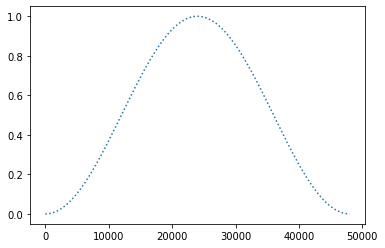

In [73]:
import matplotlib.pyplot as plt

plt.plot(w, linestyle = 'dotted')
plt.show()

# Multiply Segments by Window Function (Hann)

In [74]:
xgrid = xgrid*np.tile(w/alpha,[M,1])

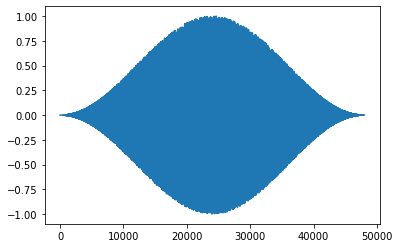

In [75]:
plt.plot(xgrid[M-1,:], linestyle = '-')
plt.show()

# Equation (7) - Compute DFT

In [76]:
X = abs(sp.fft.fft(xgrid))

np.shape(X)

(19, 48000)

# Equation (8) - Compute Power Spectrum


In [77]:
P = (X/N)**2;                      #power spectrum = square of amplitude

np.shape(P)

(19, 48000)

# Equation (9) - Compute single-sided power spectrum

remove DC (0 Hz) component and 
frequencies above Nyquist frequency
Fs/2 (index of Fs/2 = N/2+1), divide
by noise power bandwidth

In [78]:
Pss = 2*P[:,1:int(np.floor(N/2)+1)]

np.shape(Pss)

(19, 24000)

# compute frequencies of DFT bins

In [79]:
f = np.floor(Fs/2)*np.linspace(1/(N/2),1,int(N/2))

f

np.shape(f)

(24000,)

In [80]:
flow = np.where((f >= lcut) & (f<=hcut))
f = f[flow]
nf = len(f)
nf

24000

# Compute noise power bandwidth and delta(f)

In [81]:
B = (1/N)*(np.sum((w/alpha)**2))
delf = Fs/N

print(B)

1.5


In [82]:
print(flow[0])

[    0     1     2 ... 23997 23998 23999]


# 1/3 octave analysis


In [83]:
if lcut < 25:
  lcut = 25


#(Equation 13) Build TOL frequency

In [84]:
  lobandf = np.floor(np.log10(lcut)) #lowest power of 10 frequency for 1/3 
  # octave band computation
  hibandf = np.ceil(np.log10(hcut));  #highest ""
  nband = 10*(hibandf-lobandf)+1;     #number of 1/3-octave bands
  fc = np.zeros((1,int(nband)));      #initialise 1/3-octave frequency vector
  fc[0][0] = 10**lobandf;             #lowest frequency = lowest power of 10

#get the center frequencies
  for i in range(1,int(nband)):
    fc[0][i] = fc[0][i-1]*10**0.1

fc = np.squeeze(fc)
fc = fc[np.logical_and(fc>lcut, fc <=hcut)] #crop to cutoff freq's

nfc = len(fc) #number of TOL bands

print(nfc)


30


#(Equations 14-15) Calculate Boundary Frequencies for each band

In [85]:
fb = fc*10**-0.05 #calculate lower bounds from Fc
fb = np.append(fb,fc[nfc-1]*10**0.05) #calculate upper bounds from Fc
print(hcut)

24000


#(Equation 16) Calculate 1/3-octave band levels

In [152]:
P13 = np.zeros((M,nfc)) #create the array to hold the TOL data

for i in range(0, nfc): #loop through center frequencies
  fall = np.logical_and(f >= fb[i], f < fb[i+1]) #index freq's falling into band

  for q in range(0,M): # loop through DFT's of data segments
    fcl = np.sum(Pss[q,fall]) # integrate over m'th band frequencies
    P13[q,i] = fcl #store TOL value


if np.all(10*np.log10(P13[0][:]/(pref**2))  <= -10**6):
  lowcut = np.where(10*np.log10(P13[0][:]/(pref**2))  <= -10**6)

  P13 = P13[:,lowcut[np.size(lowcut)-1]:nfc-1]
  fb = fb[lowcut[np.size(lowcut)-1]:nfc]
  fc = fc[lowcut[np.size(lowcut)-1]:nfc-1]
  nfc = len(fc)

a = 10*np.log10((1/B)*P13/(pref**2))-S

# Compute Time Vector

In [176]:
tint = (1-olap)*N/Fs
ttot = M*tint-tint
t = np.linspace(0,ttot,int(ttot/tint+1))
t

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. ])

# Construct and output array

In [177]:
#a = np.ndarray.flatten(a)
#A = np.column_stack((f,np.around(a,1)))

A = np.zeros((M+1,nfc+1))

A[1:M+1,1:nfc+1] = a

A[0,1:nfc+1] = fc
A[1:M+1,0] = t
f = fc

# Plot the Data

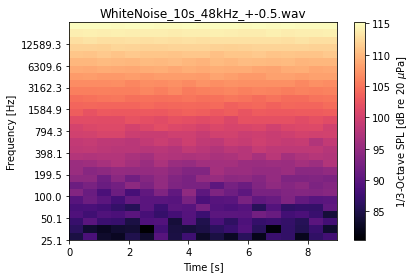

In [244]:
import matplotlib.pyplot as plt

z_min, z_max = a.min(), a.max()

fig, ax = plt.subplots()


c = ax.imshow(a.transpose(),cmap ='magma', vmin = z_min, vmax = z_max,
                 extent =[t.min(), t.max(), 0, len(f)],
                    interpolation ='none', origin ='lower', aspect='auto')
ax.ticklabel_format(useOffset=False)

ax.set_yticks(np.arange(0,30,3))
ax.set_yticklabels(np.round(f[(np.arange(0,30,3))],1))

plt.colorbar(c,label = '1/3-Octave SPL [dB re 20 $\mu$Pa]')

#plt.gca().invert_yaxis()

plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('WhiteNoise_10s_48kHz_+-0.5.wav')

plt.show()